# Interconnect Telecom Operator: Predicting Churn
In this project, the telecom operator Interconnect wants to be able to forecast their churn of clients. Clients that are identified as likely to leave can be offered promotional codes and special plan options. In order to predict customer churn, a machine learning binary classification model will be developed and tested using AUC-ROC and accuracy as metrics to evaluate the model. A threshold AUC-ROC score <u><</u>0.75 will be used to determine an adequate model.

The following steps will be taken:
1. Download libraries and data, combine data into a single data set, and address data anomalies.
2. Conduct exploratory analysis, use feature engineering to create additional variables relevant for model training and testing.
3. Prepare categorical variables for modeling (e.g., one hot encoding or label encoding depending on models).
4. Test classification algorithms, tuning hyperparameters to improve AUC-ROC and accuracy metrics.
5. Use gradient boosting (Light GBM) to determine whether it improves the quality of the model. Test CatBoost gradient boosting algorithm if threshold not achieved (min AUC-ROC 0.75).
6. Summarize process results.

## 1. Data Preparation


### 1.1 Initialization


In [1]:
# Load libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

import lightgbm as lgb

/Users/elizabethfrank/anaconda3/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


### 1.2 Load Data


In [2]:
# Load data
contract = pd.read_csv('contract.csv')

personal = pd.read_csv('personal.csv')

internet = pd.read_csv('internet.csv')

phone = pd.read_csv('phone.csv')


### 1.3 Initial Data Review

In [3]:
# Print info and sample for each data set

print('Contract data set')
contract.info()
print()
display(contract.head())
print()

print('Personal data set')
personal.info()
print()
display(personal.head())
print()

print('Internet data set')
internet.info()
print()
display(internet.head())
print()

print('Phone data set')
phone.info()
print()
display(phone.head())
print()


Contract data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Personal data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Internet data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Phone data set
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### 1.4 Merge Data and Address Anomalies

In [4]:
# Merge contract, personal, internet, and phone data

#merge contract and personal data sets
cont_pers = contract.merge(personal, on='customerID', how='outer')

#merge with phone data set
cont_pers_ph = cont_pers.merge(phone, on='customerID', how='outer')

#merge with internet data set
cont_pers_ph_int = cont_pers_ph.merge(internet, on='customerID', how='outer')

#print info and sample to confirm accurately merged
cont_pers_ph_int.info()
display(cont_pers_ph_int.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1954,5834-ASPWA,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,75.45,75.45,Male,0,No,No,Yes,Fiber optic,No,No,No,No,No,No
1191,8221-HVAYI,2017-03-01,No,Two year,Yes,Credit card (automatic),69.15,2490.15,Male,0,Yes,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No
3388,8498-XXGWA,2014-09-01,No,Month-to-month,Yes,Mailed check,55.15,3673.15,Female,0,Yes,No,No,DSL,Yes,No,Yes,No,No,No
6560,9801-NOSHQ,2018-03-01,No,One year,No,Mailed check,19.80,465.45,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6992,0218-QNVAS,2014-03-01,No,One year,No,Bank transfer (automatic),100.55,7113.75,Male,0,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes


In [5]:
# Rename columns with all lower case
cont_pers_ph_int.columns = cont_pers_ph_int.columns.str.lower()

In [6]:
# Convert variables to numeric and date types
cont_pers_ph_int['totalcharges'] = pd.to_numeric(cont_pers_ph_int['totalcharges'], errors='coerce')
cont_pers_ph_int['begindate'] = pd.to_datetime(cont_pers_ph_int['begindate'], format='%Y-%m-%d')

cont_pers_ph_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  multiplelines     6361 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

In [7]:
# Total charges missing for a subset of data - print to look at possible trend
display(cont_pers_ph_int[cont_pers_ph_int['totalcharges'].isna()])

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


In [8]:
# Display all data points with begindate of Feb 1, 2020 to confirm total charges are missing for those observations
display(cont_pers_ph_int[cont_pers_ph_int['begindate'] == '2020-02-01'])

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


In [9]:
# Fill missing total charges with monthly charges given all are Feb 2020, the last month of data collected
cont_pers_ph_int['totalcharges'] = cont_pers_ph_int['totalcharges'].fillna(cont_pers_ph_int['monthlycharges'])

#print relevant data points and sample of full data set to confirm accurately filled
display(cont_pers_ph_int[cont_pers_ph_int['begindate'] == '2020-02-01'])
display(cont_pers_ph_int.sample(5))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,20.25,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,80.85,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,56.05,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,19.85,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,25.35,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,20.00,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,19.70,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
3249,4324-BZCKL,2019-04-01,No,Month-to-month,Yes,Mailed check,55.55,551.30,Female,0,Yes,Yes,No,DSL,No,Yes,Yes,No,No,No
5492,2799-TSLAG,2014-09-01,No,Two year,Yes,Bank transfer (automatic),25.30,1748.55,Female,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,5076-YVXCM,2015-11-01,No,Month-to-month,No,Bank transfer (automatic),83.40,4149.45,Male,0,No,No,Yes,Fiber optic,No,No,No,No,No,Yes
4078,0628-CNQRM,2018-02-01,2019-12-01 00:00:00,One year,Yes,Bank transfer (automatic),67.50,1544.05,Male,0,Yes,Yes,No,DSL,Yes,No,Yes,Yes,Yes,No
5299,5569-OUICF,2017-09-01,2020-01-01 00:00:00,Month-to-month,Yes,Credit card (automatic),101.30,2812.20,Female,1,Yes,No,Yes,Fiber optic,No,No,No,Yes,Yes,Yes


In [10]:
# Fill missing multiplelines w/"no_service" as they don't have that plan service

cont_pers_ph_int['multiplelines'] = cont_pers_ph_int['multiplelines'].fillna('no_service')

#print sample to confirm accurately changed
display(cont_pers_ph_int.sample(10))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
5029,1848-LBZHY,2019-07-01,No,Month-to-month,Yes,Bank transfer (automatic),50.30,355.10,Female,0,Yes,No,No,DSL,Yes,No,No,No,No,No
988,9046-JBFWA,2017-11-01,No,Month-to-month,No,Mailed check,19.15,537.35,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6166,4077-CROMM,2017-03-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,104.20,3243.45,Female,0,Yes,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
4599,1834-ABKHQ,2015-10-01,No,One year,Yes,Bank transfer (automatic),50.95,2610.65,Female,0,Yes,Yes,No,DSL,No,No,Yes,No,No,No
4543,7216-KAOID,2016-09-01,No,One year,No,Bank transfer (automatic),19.50,798.20,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2947,5131-PONJI,2016-01-01,No,Month-to-month,Yes,Credit card (automatic),90.40,4494.65,Male,0,Yes,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No
1293,3022-BEXHZ,2014-07-01,No,Two year,Yes,Bank transfer (automatic),111.20,7530.80,Male,0,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
296,6556-DBKZF,2014-03-01,No,Two year,No,Electronic check,76.05,5436.45,Female,0,Yes,Yes,No,Fiber optic,No,No,Yes,No,No,No
2036,8775-ERLNB,2020-01-01,No,Month-to-month,No,Electronic check,74.30,74.30,Male,1,Yes,No,Yes,Fiber optic,No,No,No,No,No,No
6111,9812-GHVRI,2016-10-01,No,Month-to-month,No,Bank transfer (automatic),83.85,3532.25,Female,0,No,No,Yes,Fiber optic,No,No,No,No,No,Yes


In [11]:
# Fill missing variables for internet services w/"no_service" as they don't have that plan service

cont_pers_ph_int[['internetservice', 
                  'onlinesecurity', 
                  'onlinebackup', 
                  'deviceprotection', 
                  'techsupport', 
                  'streamingtv', 
                  'streamingmovies']] = cont_pers_ph_int[['internetservice', 
                                                          'onlinesecurity', 
                                                          'onlinebackup', 
                                                          'deviceprotection', 
                                                          'techsupport', 
                                                          'streamingtv', 
                                                          'streamingmovies']].fillna('no_service')

#print sample to confirm accurately changed
display(cont_pers_ph_int.sample(10))


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
4649,5172-RKOCB,2014-02-01,No,Two year,Yes,Credit card (automatic),108.95,7875.00,Male,0,Yes,No,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
5451,1696-HXOWK,2014-03-01,No,One year,No,Mailed check,95.65,6856.95,Female,0,Yes,No,Yes,Fiber optic,Yes,Yes,No,No,Yes,No
91,2424-WVHPL,2020-01-01,No,Month-to-month,No,Electronic check,74.70,74.70,Male,1,No,No,No,Fiber optic,No,No,No,Yes,No,No
4541,9058-CBREO,2019-12-01,2020-01-01 00:00:00,Month-to-month,No,Mailed check,50.55,50.55,Female,1,No,No,Yes,DSL,No,No,No,No,No,No
5079,2507-QZPQS,2018-11-01,No,Month-to-month,No,Electronic check,95.70,1451.10,Male,0,No,No,Yes,Fiber optic,No,Yes,No,Yes,No,Yes
601,5173-ZXXXL,2019-12-01,No,One year,No,Mailed check,19.95,47.70,Male,0,No,No,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service
5876,4844-JJWUY,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,86.00,86.00,Female,1,No,No,No,Fiber optic,No,Yes,No,No,No,Yes
4428,5449-FIBXJ,2018-05-01,2019-12-01 00:00:00,Month-to-month,No,Electronic check,103.30,2012.70,Male,0,Yes,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
890,5898-IGSLP,2017-07-01,No,Month-to-month,No,Electronic check,89.30,2823.00,Male,0,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,No,No
3739,5789-LDFXO,2018-02-01,No,One year,No,Electronic check,24.60,592.65,Male,0,No,No,Yes,no_service,no_service,no_service,no_service,no_service,no_service,no_service


In [12]:
# Check for duplicates

print(cont_pers_ph_int.duplicated().sum())

0


In [13]:
# Print descriptive stats to check for anomalies

display(cont_pers_ph_int.describe())

,begindate,monthlycharges,totalcharges,seniorcitizen
count,7043,7043.000000,7043.000000,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692,2279.798992,0.162147
min,2013-10-01 00:00:00,18.250000,18.800000,0.000000
25%,2015-06-01 00:00:00,35.500000,398.550000,0.000000
50%,2017-09-01 00:00:00,70.350000,1394.550000,0.000000
75%,2019-04-01 00:00:00,89.850000,3786.600000,0.000000
max,2020-02-01 00:00:00,118.750000,8684.800000,1.000000
std,NaN,30.090047,2266.730170,0.368612


**Results and Conclusions**
Libraries and data were loaded and initial review completed. The data sets (contract, personal, internet, and phone) were merged based on customer ID number. The following variables were changed from object data types to numeric (totalcharges) and datetime type (begindate). There were a small number of data points (n=11) with missing data in the contract data set which were determined to be from the last month where data was collected (i.e., only one month of charges); the missing data points were replaced with the monthly charges for that month for those observations. After merging data sets, there were customers without "phone" data (i.e., multiplelines variable NaN) and without "internet" data, which are customers that do not have phone or internet service as part of their plan. NaN were replaced with "no_service" for those observations in relevant column. There were no duplicate data and descriptive statistics showed no other major anomalies.

## 2. Exploratory Data Analysis
As part of exploratory analysis, feature engineering will be used to create new variables relevant for analysis, and quantitative and qualitative variables analyzed. 

### 2.1 Feature Engineering

In [14]:
# Create churn variable to use as target variable

def churn(enddate):
    if enddate == 'No':
        return 0 #not churned
    else:
        return 1 #churned

cont_pers_ph_int['churn'] = cont_pers_ph_int['enddate'].apply(churn)

display(cont_pers_ph_int.sample(5))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,churn
3990,6986-IXNDM,2018-12-01,No,Month-to-month,Yes,Electronic check,92.90,1337.45,Male,0,...,No,No,Fiber optic,No,No,No,No,Yes,Yes,0
2282,1587-FKLZB,2014-07-01,2020-01-01 00:00:00,Month-to-month,Yes,Credit card (automatic),99.50,6822.15,Male,1,...,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,1
2057,2189-UXTKY,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,79.20,1742.75,Female,0,...,No,Yes,DSL,Yes,No,No,Yes,Yes,Yes,1
3609,4488-KQFDT,2015-01-01,No,One year,Yes,Electronic check,103.95,6423.00,Female,0,...,No,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
4630,1852-XEMDW,2018-04-01,No,Month-to-month,No,Mailed check,65.05,1427.55,Male,0,...,No,Yes,DSL,Yes,Yes,Yes,No,No,No,0


In [15]:
# Create variable total time begindate to enddate if churned or to Feb 1 2020 (last data collection point) if not churned

def length_cust(row):
    finaldate = pd.to_datetime('2020-02-01', format='%Y-%m-%d')
    if row['churn'] == 0:
        return finaldate - row['begindate']
    else:
        churn_date = pd.to_datetime(row['enddate'], format='%Y-%m-%d %H:%M:%S')
        return churn_date - row['begindate']

cont_pers_ph_int['length_cust'] = cont_pers_ph_int.apply(length_cust, axis=1)

display(cont_pers_ph_int.sample(5))

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,churn,length_cust
3920,6339-TBELP,2014-03-01,No,Two year,Yes,Credit card (automatic),86.4,6172.00,Male,0,...,Yes,Fiber optic,No,No,Yes,Yes,No,No,0,2163 days
3091,8189-DUKMV,2019-10-01,No,One year,No,Bank transfer (automatic),20.5,79.05,Female,0,...,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0,123 days
5187,2080-CAZNM,2016-09-01,No,Month-to-month,Yes,Electronic check,104.4,4133.95,Female,1,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0,1248 days
5455,9970-QBCDA,2019-08-01,No,Month-to-month,No,Credit card (automatic),19.7,129.55,Female,0,...,No,no_service,no_service,no_service,no_service,no_service,no_service,no_service,0,184 days
2161,5159-YFPKQ,2019-11-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,75.8,160.75,Female,0,...,No,Fiber optic,No,No,Yes,No,No,No,1,61 days


### 2.2 Graph Target Variable

churn
0    5174
1    1869
Name: customerid, dtype: int64

churn
0    0.73463
1    0.26537
Name: customerid, dtype: float64

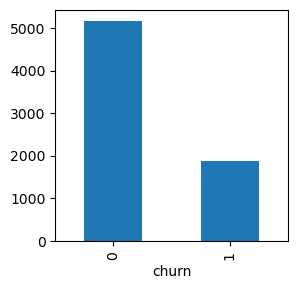

In [16]:
# Graph target variable (churn)

a = cont_pers_ph_int.groupby('churn').count()
a1 = a / cont_pers_ph_int.count()
display(a['customerid'])
display(a1['customerid'])
a['customerid'].plot(kind='bar', figsize=[3, 3])
plt.show()

### 2.3 Compare Churn and Non-Churn Customers

Avg charges
Total Charges Average 2279.798991906858
Monthly Charges Average 64.76169246059918


,monthlycharges,totalcharges
churn,,
0,61.265124,2549.999497
1,74.441332,1531.796094


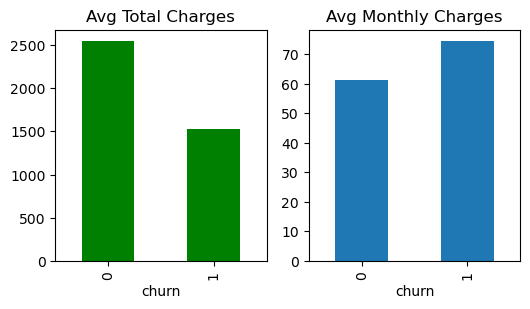

Count and Proportion paperless billing
paperlessbilling
Yes    4171
No     2872
Name: count, dtype: int64

paperlessbilling
Yes    0.592219
No     0.407781
Name: count, dtype: float64


churn  paperlessbilling
0      No                  2403
       Yes                 2771
1      No                   469
       Yes                 1400
Name: customerid, dtype: int64

churn  paperlessbilling
0      No                  0.464438
       Yes                 0.535562
1      No                  0.250936
       Yes                 0.749064
Name: customerid, dtype: float64


Type contract
type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64

type
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: count, dtype: float64


churn  type          
0      Month-to-month    2220
       One year          1307
       Two year          1647
1      Month-to-month    1655
       One year           166
       Two year            48
Name: customerid, dtype: int64

churn  type          
0      Month-to-month    0.429068
       One year          0.252609
       Two year          0.318322
1      Month-to-month    0.885500
       One year          0.088818
       Two year          0.025682
Name: customerid, dtype: float64


Payment Method contract
paymentmethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64

paymentmethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: count, dtype: float64


churn  paymentmethod            
0      Bank transfer (automatic)    1286
       Credit card (automatic)      1290
       Electronic check             1294
       Mailed check                 1304
1      Bank transfer (automatic)     258
       Credit card (automatic)       232
       Electronic check             1071
       Mailed check                  308
Name: customerid, dtype: int64

churn  paymentmethod            
0      Bank transfer (automatic)    0.248550
       Credit card (automatic)      0.249324
       Electronic check             0.250097
       Mailed check                 0.252029
1      Bank transfer (automatic)    0.138042
       Credit card (automatic)      0.124131
       Electronic check             0.573034
       Mailed check                 0.164794
Name: customerid, dtype: float64


Avg length customer
All customers 985 days 23:54:28.777509568
Current customers 1144 days 10:44:01.206030144
Customers that have left 547 days 08:26:57.977528088

Count and Proportion Gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

gender
Male      0.504756
Female    0.495244
Name: count, dtype: float64


churn  gender
0      Female    2549
       Male      2625
1      Female     939
       Male       930
Name: customerid, dtype: int64

churn  gender
0      Female    0.492656
       Male      0.507344
1      Female    0.502408
       Male      0.497592
Name: customerid, dtype: float64


Count and Proportion Senior Citizen
seniorcitizen
0    5901
1    1142
Name: count, dtype: int64

seniorcitizen
0    0.837853
1    0.162147
Name: count, dtype: float64


churn  seniorcitizen
0      0                4508
       1                 666
1      0                1393
       1                 476
Name: customerid, dtype: int64

churn  seniorcitizen
0      0                0.871279
       1                0.128721
1      0                0.745318
       1                0.254682
Name: customerid, dtype: float64


Count and Proportion Partner
partner
No     3641
Yes    3402
Name: count, dtype: int64

partner
No     0.516967
Yes    0.483033
Name: count, dtype: float64


churn  partner
0      No         2441
       Yes        2733
1      No         1200
       Yes         669
Name: customerid, dtype: int64

churn  partner
0      No         0.471782
       Yes        0.528218
1      No         0.642055
       Yes        0.357945
Name: customerid, dtype: float64


Count and Proportion Dependents
dependents
No     4933
Yes    2110
Name: count, dtype: int64

dependents
No     0.700412
Yes    0.299588
Name: count, dtype: float64


churn  dependents
0      No            3390
       Yes           1784
1      No            1543
       Yes            326
Name: customerid, dtype: int64

churn  dependents
0      No            0.655199
       Yes           0.344801
1      No            0.825575
       Yes           0.174425
Name: customerid, dtype: float64


Count and Proportion phone


churn  multiplelines
0      No               2541
       Yes              2121
       no_service        512
1      No                849
       Yes               850
       no_service        170
Name: customerid, dtype: int64

churn  multiplelines
0      No               0.491109
       Yes              0.409934
       no_service       0.098956
1      No               0.454254
       Yes              0.454789
       no_service       0.090958
Name: customerid, dtype: float64


Count and Proportion internet service


churn  internetservice
0      DSL                1962
       Fiber optic        1799
       no_service         1413
1      DSL                 459
       Fiber optic        1297
       no_service          113
Name: customerid, dtype: int64

churn  internetservice
0      DSL                0.379204
       Fiber optic        0.347700
       no_service         0.273096
1      DSL                0.245586
       Fiber optic        0.693954
       no_service         0.060460
Name: customerid, dtype: float64

In [17]:
# Compare averages and proportions for churn vs. not

#charges
print('Avg charges')
print('Total Charges Average', cont_pers_ph_int['totalcharges'].mean())
print('Monthly Charges Average', cont_pers_ph_int['monthlycharges'].mean())
b = cont_pers_ph_int.groupby(['churn'])[['monthlycharges', 'totalcharges']].mean()
display(b)

#graph charges
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
b['totalcharges'].plot(kind='bar', ax=axes[0], color='green', title='Avg Total Charges')
b['monthlycharges'].plot(kind='bar', ax=axes[1], title='Avg Monthly Charges')
plt.show()


#paperless billing
print('Count and Proportion paperless billing')
print(cont_pers_ph_int['paperlessbilling'].value_counts())
print()
print(cont_pers_ph_int['paperlessbilling'].value_counts()/cont_pers_ph_int['customerid'].count())
c = cont_pers_ph_int.groupby(['churn', 'paperlessbilling'])['customerid'].count()
c1 = cont_pers_ph_int.groupby(['churn'])['customerid'].count()
c2 = c / c1
display(c)
display(c2)
print()


#type contract
print('Type contract')
print(cont_pers_ph_int['type'].value_counts())
print()
print(cont_pers_ph_int['type'].value_counts()/cont_pers_ph_int['customerid'].count())
d = cont_pers_ph_int.groupby(['churn', 'type'])['customerid'].count()
d2 = d / c1
display (d)
display (d2)
print()


#payment method
print('Payment Method contract')
print(cont_pers_ph_int['paymentmethod'].value_counts())
print()
print(cont_pers_ph_int['paymentmethod'].value_counts()/cont_pers_ph_int['customerid'].count())
e = cont_pers_ph_int.groupby(['churn', 'paymentmethod'])['customerid'].count()
e2 = e / c1
display (e)
display (e2)
print()


#length customer
print('Avg length customer')
cont_pers_ph_int['length_cust_idx'] = pd.to_timedelta(cont_pers_ph_int['length_cust'], unit='D')
print('All customers', cont_pers_ph_int['length_cust_idx'].mean())
f = cont_pers_ph_int[cont_pers_ph_int['churn'] == 0]
print('Current customers', f['length_cust_idx'].mean())
f_1 = cont_pers_ph_int[cont_pers_ph_int['churn'] == 1]
print('Customers that have left', f_1['length_cust_idx'].mean())
print()


#gender
print('Count and Proportion Gender')
print(cont_pers_ph_int['gender'].value_counts())
print()
print(cont_pers_ph_int['gender'].value_counts()/cont_pers_ph_int['customerid'].count())
g = cont_pers_ph_int.groupby(['churn', 'gender'])['customerid'].count()
g2 = g / c1
display(g)
display(g2)
print()


#senior citizens
print('Count and Proportion Senior Citizen')
print(cont_pers_ph_int['seniorcitizen'].value_counts())
print()
print(cont_pers_ph_int['seniorcitizen'].value_counts()/cont_pers_ph_int['customerid'].count())
h = cont_pers_ph_int.groupby(['churn', 'seniorcitizen'])['customerid'].count()
h2 = h / c1
display(h)
display(h2)
print()


#partner
print('Count and Proportion Partner')
print(cont_pers_ph_int['partner'].value_counts())
print()
print(cont_pers_ph_int['partner'].value_counts()/cont_pers_ph_int['customerid'].count())
j = cont_pers_ph_int.groupby(['churn', 'partner'])['customerid'].count()
j2 = j / c1
display(j)
display(j2)
print()


#dependents
print('Count and Proportion Dependents')
print(cont_pers_ph_int['dependents'].value_counts())
print()
print(cont_pers_ph_int['dependents'].value_counts()/cont_pers_ph_int['customerid'].count())
k = cont_pers_ph_int.groupby(['churn', 'dependents'])['customerid'].count()
k2 = k / c1
display(k)
display(k2)
print()


#phone data
print('Count and Proportion phone')
m = cont_pers_ph_int.groupby(['churn', 'multiplelines'])['customerid'].count()
m2 = m / c1
display(m)
display(m2)
print()

#internetservice
print('Count and Proportion internet service')
n = cont_pers_ph_int.groupby(['churn', 'internetservice'])['customerid'].count()
n2 = n / c1
display(n)
display(n2)
print()


**Results and Conclusions**
The merged data set (contract, personal, phone) was used for exploratory data analysis (EDA). Feature engineering was used to create two new variables: a) churn variable indicating whether a customer had closed their account (1) or not (0) that will be used as the target variable, and b) a variable (length_cust) that calculates the total number of days a customer has been active (either until they left or until the last point of data collection if still active). This can be used as a feature variable, dropping begindate and enddate to avoid data leakage. 

The majority of customers have paperless billing (59%), month-to-month contracts (55%), are not senior citizens (84% not senior citizens), have no partner (52%), and have no dependents (70%). Gender was nearly evenly split (50% male, 50% female), as was the partner variable (52% no partner vs. 48% partner). Of four billing options, approx one-third (34%) pay by electronic check, with proportions nearly evenly split among the other three options (approx 22% for each).

Data was compared for individuals that had left or not (churn), the target variable, including total numbers, and comparisons for the two groups for other variables. Approx three-quarters of customers were still active in the data set (n=5163 or 73%), indicating a class imbalance that will be addressed in model development. 

Average monthly charges were higher for those that had left (74.44 vs. 61.31) while total charges were higher for active customers (2,555.34 vs. 1,531.80). Customers that had left had higher rates of paperless billing (75% vs. 54% active customers), more month-to-month contract types (89% for churned customers vs. 43% active), and paid more often by electronic check (57% churned customers vs. 25% active). Gender proportions were similar for customers that had left or not (50% female for those that had left vs. 49% active customers), while customers that had left were more likely to be older (25% senior citizens vs. 13%), less likely to have a partner (36% vs. 53%), and less likely to have dependents (17% vs. 34%). Active customers had a tenure of 1,146 days vs. 547 days for those that had left. Customers with phone plans vs. not were similar for active customers (10% without phone plans in their overall plan) and churned customers (9% without phone plans). By contrast, the proportion of customers without internet plans among active clients (27% no internet service) was higher than those that had churned (6% no internet service).

## 3. Model Development and Validation

Functions are created that will be used with various models. Logistic Regression, Random Forest Classifier, and Light GBM (gradient boosting) models are developed, trained, and tuned with hyperparameters. Categorical vairables are transformed with one-hot encoding or label encoding as relevant. Class imbalances of the target variable are addressed through upsampling, downsampling, and balancing class weights within models as relevant. Thresholds to optimize metrics are also adjusted. AUC-ROC is the main metric to assess models, but accuracy is also measured. The best fit model is identified based on model development, hyperparameter tuning and metrics.

In [18]:
# Create upsample function for positive target class data given class imbalance

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled
    

In [19]:
# Create function to find best fraction for upsampling

def find_repeat(model, features_t, target_t, features_v, target_v):
    best_score = 0
    best_repeat = 0
    for repeat in range(1, 20):
        features_upsampled, target_upsampled = upsample(features_t, target_t, repeat)
        model.fit(features_upsampled, target_upsampled)
        valid_predict = model.predict(features_v)
        score = roc_auc_score(target_v, valid_predict)
        if score > best_score:
            best_score = score
            best_repeat = repeat
    return best_score, best_repeat, model

In [20]:
# Create downsample function for positive target class data given class imbalance
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

In [21]:
# Create function to find best fraction for downsampling

def find_frac(model, features_t, target_t, features_v, target_v):
    best_score = 0
    best_fraction = 0
    for i in range(1, 100):
        fraction = i/100
        features_downsampled, target_downsampled = downsample(features_t, target_t, fraction)
        model.fit(features_downsampled, target_downsampled)
        valid_predict = model.predict(features_v)
        score = roc_auc_score(target_v, valid_predict)
        if score > best_score:
            best_score = score
            best_fraction = fraction

    return best_score, best_fraction, model

In [22]:
# Create function to find best threshold to optimize score after running model

def find_threshold(model, features_v, target_v):
    best_score_valid = 0
    best_threshold = 0
    for i in range(1, 100):
        threshold = i/100
        valid_predict_i = model.predict_proba(features_v)
        valid_predict = (valid_predict_i [:, 1] >= threshold).astype('int')
        score = roc_auc_score(target_v, valid_predict)
        if score > best_score_valid:
            best_score_valid = score
            best_threshold = threshold
    return best_score_valid, best_threshold, model


### 3.1 Logistic Regression

In [23]:
# Create target data set, i.e., churn
target_lr = cont_pers_ph_int['churn']

# Create features for model
features_lr = cont_pers_ph_int.drop(['churn', 
                                'enddate', 
                                'begindate', 
                                'length_cust', 
                                'length_cust_idx', 
                                'customerid'], 
                                axis=1)


In [24]:
# Transform categorical variables to numeric in features data set with OHE
features_lr_ohe = pd.get_dummies(features_lr[['type', 
                                            'paperlessbilling', 
                                            'paymentmethod', 
                                            'gender', 
                                            'partner', 
                                            'dependents', 
                                            'multiplelines',
                                            'internetservice',
                                            'onlinesecurity',
                                            'onlinebackup',
                                            'deviceprotection',
                                            'techsupport',
                                            'streamingtv',
                                            'streamingmovies']], 
                                            drop_first=True)

features_lr_ohe = features_lr.merge(features_lr_ohe, left_index=True, right_index=True).drop(['type', 
                                                                                            'paperlessbilling', 
                                                                                            'paymentmethod', 
                                                                                            'gender', 
                                                                                            'partner', 
                                                                                            'dependents', 
                                                                                            'multiplelines',
                                                                                            'internetservice',
                                                                                            'onlinesecurity',
                                                                                            'onlinebackup',
                                                                                            'deviceprotection',
                                                                                            'techsupport',
                                                                                            'streamingtv',
                                                                                            'streamingmovies'], 
                                                                                            axis=1)

features_lr_ohe.info()
display(features_lr_ohe.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         7043 non-null   float64
 1   totalcharges                           7043 non-null   float64
 2   seniorcitizen                          7043 non-null   int64  
 3   type_One year                          7043 non-null   bool   
 4   type_Two year                          7043 non-null   bool   
 5   paperlessbilling_Yes                   7043 non-null   bool   
 6   paymentmethod_Credit card (automatic)  7043 non-null   bool   
 7   paymentmethod_Electronic check         7043 non-null   bool   
 8   paymentmethod_Mailed check             7043 non-null   bool   
 9   gender_Male                            7043 non-null   bool   
 10  partner_Yes                            7043 non-null   bool   
 11  depe

,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,...,onlinebackup_Yes,onlinebackup_no_service,deviceprotection_Yes,deviceprotection_no_service,techsupport_Yes,techsupport_no_service,streamingtv_Yes,streamingtv_no_service,streamingmovies_Yes,streamingmovies_no_service
3325,85.65,338.90,0,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
6819,98.80,5617.75,1,False,False,True,False,True,False,True,...,False,False,False,False,False,False,True,False,True,False
3844,85.95,3110.10,0,True,False,True,True,False,False,False,...,False,False,True,False,True,False,True,False,True,False
5469,79.00,2576.80,0,False,False,True,True,False,False,True,...,True,False,True,False,False,False,False,False,False,False
2514,89.70,2187.55,1,False,False,True,False,True,False,False,...,True,False,False,False,False,False,False,False,True,False


In [25]:
# Split data into subsets with 3:1:1 ration - training (60%), test (20%) and validation (20%)

features_lr_i, features_lr_test, target_lr_i, target_lr_test = train_test_split(features_lr_ohe, target_lr, test_size=0.2, random_state=12345)

features_lr_train, features_lr_valid, target_lr_train, target_lr_valid = train_test_split(features_lr_i, target_lr_i, test_size=0.25, random_state=12345)

#print info to confirm accurately split
print('Training dataset')
features_lr_train.info()
print()

print('Validataion dataset')
features_lr_valid.info()
print()

print('Test dataset')
features_lr_test.info()


Training dataset
<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 940 to 288
Data columns (total 28 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   monthlycharges                         4225 non-null   float64
 1   totalcharges                           4225 non-null   float64
 2   seniorcitizen                          4225 non-null   int64  
 3   type_One year                          4225 non-null   bool   
 4   type_Two year                          4225 non-null   bool   
 5   paperlessbilling_Yes                   4225 non-null   bool   
 6   paymentmethod_Credit card (automatic)  4225 non-null   bool   
 7   paymentmethod_Electronic check         4225 non-null   bool   
 8   paymentmethod_Mailed check             4225 non-null   bool   
 9   gender_Male                            4225 non-null   bool   
 10  partner_Yes                            4225 non-null   bool

In [26]:
# Standardize numeric scales for relevant variables

scaler = StandardScaler()
numeric = ['monthlycharges', 'totalcharges']
scaler.fit(features_lr_train.loc[:, numeric])

features_lr_train.loc[:, numeric] = scaler.transform(features_lr_train.loc[:, numeric])
features_lr_valid.loc[:, numeric] = scaler.transform(features_lr_valid.loc[:, numeric])
features_lr_test.loc[:, numeric] = scaler.transform(features_lr_test.loc[:, numeric])

# Confirm transformed appropriately
display(features_lr_train.sample(5))
display(features_lr_valid.sample(5))
display(features_lr_test.sample(5))

,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,...,onlinebackup_Yes,onlinebackup_no_service,deviceprotection_Yes,deviceprotection_no_service,techsupport_Yes,techsupport_no_service,streamingtv_Yes,streamingtv_no_service,streamingmovies_Yes,streamingmovies_no_service
4712,1.429416,1.391920,0,True,False,True,False,True,False,True,...,True,False,True,False,False,False,True,False,True,False
451,0.148185,-0.333785,1,False,False,True,False,False,True,False,...,False,False,True,False,True,False,False,False,True,False
3510,0.331218,-0.763967,0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1261,0.494284,-0.933674,0,False,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
627,1.307948,2.008329,1,True,False,False,True,False,False,False,...,True,False,True,False,False,False,True,False,True,False


,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,...,onlinebackup_Yes,onlinebackup_no_service,deviceprotection_Yes,deviceprotection_no_service,techsupport_Yes,techsupport_no_service,streamingtv_Yes,streamingtv_no_service,streamingmovies_Yes,streamingmovies_no_service
5128,1.144883,1.088079,1,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
1809,0.655685,0.153218,1,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
459,0.326226,-0.986719,0,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
3195,0.507595,-0.729684,0,False,False,False,False,True,False,False,...,True,False,True,False,False,False,False,False,False,False
2069,1.008440,-0.977616,0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False


,monthlycharges,totalcharges,seniorcitizen,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,gender_Male,...,onlinebackup_Yes,onlinebackup_no_service,deviceprotection_Yes,deviceprotection_no_service,techsupport_Yes,techsupport_no_service,streamingtv_Yes,streamingtv_no_service,streamingmovies_Yes,streamingmovies_no_service
6232,1.171506,-0.791811,0,False,False,True,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
6037,1.467686,2.102474,1,False,False,True,False,False,False,True,...,True,False,True,False,False,False,True,False,True,False
542,-1.522407,-1.011388,0,False,False,False,False,False,True,False,...,False,True,False,True,False,True,False,True,False,True
2081,0.332882,-0.263842,0,False,False,True,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4068,-1.524071,-0.899279,0,True,False,True,False,False,True,False,...,False,True,False,True,False,True,False,True,False,True


In [27]:
# Logistic Regression Model training

model_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_lr.fit(features_lr_train, target_lr_train)

train_predictions_lr = model_lr.predict(features_lr_train)
valid_predictions_lr = model_lr.predict(features_lr_valid)

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_lr_train, train_predictions_lr))
print('Validation set:', roc_auc_score(target_lr_valid, valid_predictions_lr))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_lr_train, train_predictions_lr))
print('Validation set:', accuracy_score(target_lr_valid, valid_predictions_lr))


AUC-ROC Logistic Regression Model
Training set: 0.7237042075090799
Validation set: 0.6920202377886514

Accuracy Logistic Regression Model
Training set: 0.8028402366863905
Validation set: 0.7955997161107168


In [28]:
# Run upsampling functions to improve model

print('Upsampling')
find_repeat(model_lr, features_lr_train, target_lr_train, features_lr_valid, target_lr_valid)


Upsampling


(0.7390789981972702,
 2,
 LogisticRegression(random_state=12345, solver='liblinear'))

In [29]:
# Run downsampling functions to improve model

print('Downsampling')
find_frac(model_lr, features_lr_train, target_lr_train, features_lr_valid, target_lr_valid)

Downsampling


(0.7437615353249206,
 0.42,
 LogisticRegression(random_state=12345, solver='liblinear'))

In [30]:
# Run model with class weight adjustment

model_lr_bal = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')

model_lr_bal.fit(features_lr_train, target_lr_train)

train_predictions_lr = model_lr_bal.predict(features_lr_train)
valid_predictions_lr = model_lr_bal.predict(features_lr_valid)

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_lr_train, train_predictions_lr))
print('Validation set:', roc_auc_score(target_lr_valid, valid_predictions_lr))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_lr_train, train_predictions_lr))
print('Validation set:', accuracy_score(target_lr_valid, valid_predictions_lr))

AUC-ROC Logistic Regression Model
Training set: 0.7661066926873282
Validation set: 0.7427662782213066

Accuracy Logistic Regression Model
Training set: 0.7531360946745562
Validation set: 0.7345635202271115


In [31]:
# Create downsampled training data given best fit model

best_score_valid, best_fraction, model = find_frac(model_lr, features_lr_train, target_lr_train, features_lr_valid, target_lr_valid)

features_downsampled, target_downsampled = downsample(features_lr_train, target_lr_train, best_fraction)


In [32]:

# Apply function to find best threshold to optimize model with upsampled data

model_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_lr.fit(features_downsampled, target_downsampled)

find_threshold(model_lr, features_lr_valid, target_lr_valid)


(0.7437615353249206,
 0.5,
 LogisticRegression(random_state=12345, solver='liblinear'))

In [33]:
# AUC-ROC and Accuracy metrics for best fit LR model

model_lr = LogisticRegression(random_state=12345, solver='liblinear')

model_lr.fit(features_downsampled, target_downsampled)

best_score_valid, best_threshold, model = find_threshold(model_lr, features_lr_valid, target_lr_valid)
#then try with model as model_lr

train_predictions_lr = model_lr.predict(features_downsampled)

valid_predict_i = model_lr.predict_proba(features_lr_valid)
valid_predictions_lr = (valid_predict_i [:, 1] >= best_threshold).astype('int')

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_downsampled, train_predictions_lr))
print('Validation set:', roc_auc_score(target_lr_valid, valid_predictions_lr))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_downsampled, train_predictions_lr))
print('Validation set:', accuracy_score(target_lr_valid, valid_predictions_lr))


AUC-ROC Logistic Regression Model
Training set: 0.7652294822840612
Validation set: 0.7437615353249206

Accuracy Logistic Regression Model
Training set: 0.7654067378800329
Validation set: 0.7530163236337828


### 3.2 Random Forest

In [34]:
# Use label encoding for categorical features for Random Forest Classifier

encoder = OrdinalEncoder()
features_rf = features_lr[['type', 
                        'paperlessbilling', 
                        'paymentmethod', 
                        'gender', 
                        'partner', 
                        'dependents', 
                        'multiplelines',
                        'internetservice',
                        'onlinesecurity',
                        'onlinebackup',
                        'deviceprotection',
                        'techsupport',
                        'streamingtv',
                        'streamingmovies']]

features_rf = pd.DataFrame(encoder.fit_transform(features_rf), columns=features_rf.columns)

features_rf = features_lr.merge(features_rf, left_index=True, right_index=True).drop(['type_x', 
                                                                                            'paperlessbilling_x', 
                                                                                            'paymentmethod_x', 
                                                                                            'gender_x', 
                                                                                            'partner_x', 
                                                                                            'dependents_x', 
                                                                                            'multiplelines_x',
                                                                                            'internetservice_x',
                                                                                            'onlinesecurity_x',
                                                                                            'onlinebackup_x',
                                                                                            'deviceprotection_x',
                                                                                            'techsupport_x',
                                                                                            'streamingtv_x',
                                                                                            'streamingmovies_x'], 
                                                                                            axis=1)

# Confirm transformed appropriately
display(features_rf.sample(5))

,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
4074,98.70,5812.60,1,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
5801,75.55,2425.40,1,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4101,59.15,336.70,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6469,21.45,705.45,0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1663,94.65,4812.75,0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [35]:
# Split data into subsets with 3:1:1 ration - training (60%), test (20%) and validation (20%)

features_rf_i, features_rf_test, target_rf_i, target_rf_test = train_test_split(features_rf, target_lr, test_size=0.2, random_state=12345)

features_rf_train, features_rf_valid, target_rf_train, target_rf_valid = train_test_split(features_rf_i, target_rf_i, test_size=0.25, random_state=12345)

#print info to confirm accurately split
print('Training dataset')
features_rf_train.info()
print()

print('Validataion dataset')
features_rf_valid.info()
print()

print('Test dataset')
features_rf_test.info()


Training dataset
<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 940 to 288
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   monthlycharges      4225 non-null   float64
 1   totalcharges        4225 non-null   float64
 2   seniorcitizen       4225 non-null   int64  
 3   type_y              4225 non-null   float64
 4   paperlessbilling_y  4225 non-null   float64
 5   paymentmethod_y     4225 non-null   float64
 6   gender_y            4225 non-null   float64
 7   partner_y           4225 non-null   float64
 8   dependents_y        4225 non-null   float64
 9   multiplelines_y     4225 non-null   float64
 10  internetservice_y   4225 non-null   float64
 11  onlinesecurity_y    4225 non-null   float64
 12  onlinebackup_y      4225 non-null   float64
 13  deviceprotection_y  4225 non-null   float64
 14  techsupport_y       4225 non-null   float64
 15  streamingtv_y       4225 non-null   float6

In [36]:
# Standardize numeric scales for relevant variables

scaler = StandardScaler()
numeric = ['monthlycharges', 'totalcharges']
scaler.fit(features_rf_train.loc[:, numeric])

features_rf_train.loc[:, numeric] = scaler.transform(features_rf_train.loc[:, numeric])
features_rf_valid.loc[:, numeric] = scaler.transform(features_rf_valid.loc[:, numeric])
features_rf_test.loc[:, numeric] = scaler.transform(features_rf_test.loc[:, numeric])

# Confirm transformed appropriately
display(features_rf_train.sample(5))
display(features_rf_valid.sample(5))
display(features_rf_test.sample(5))

,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
3531,-1.529063,-0.888821,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
6415,-0.663816,0.107944,0,1.0,1.0,2.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
6251,-1.532391,-1.011521,0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1677,-1.327727,-0.951992,0,2.0,0.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2772,0.289619,1.141902,0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
6187,-1.502440,-0.946574,0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1455,1.356203,0.682720,0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
5650,-0.182938,0.020793,0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
2287,1.434408,2.229815,1,2.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
5404,1.010104,1.051220,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
5514,-0.560652,-0.998554,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5489,-1.334382,-0.877497,0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3683,-0.359316,0.657763,0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2291,0.677317,-0.877231,0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
751,0.494284,1.466859,0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0


In [37]:
# Random Forest Classification Model training

model_rf = RandomForestClassifier(random_state=12345)

model_rf.fit(features_rf_train, target_rf_train)

train_predictions_rf = model_rf.predict(features_rf_train)
valid_predictions_rf = model_rf.predict(features_rf_valid)

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_rf_train, train_predictions_rf))
print('Validation set:', roc_auc_score(target_rf_valid, valid_predictions_rf))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_rf_train, train_predictions_rf))
print('Validation set:', accuracy_score(target_rf_valid, valid_predictions_rf))


AUC-ROC Logistic Regression Model
Training set: 0.9980330703924973
Validation set: 0.690126298394712

Accuracy Logistic Regression Model
Training set: 0.9983431952662722
Validation set: 0.7927608232789212


In [38]:
# Adjust hyperparameters to find best fit

best_score = 0
best_depth = 0
for depth in range(1, 100):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=depth)
    model_rf.fit(features_rf_train, target_rf_train)
    predictions_rf = model_rf.predict(features_rf_valid)
    score = roc_auc_score(target_rf_valid, predictions_rf)
    if score > best_score:
        best_score = score
        best_depth = depth

print('AUC-ROC Score on validation set (max_depth = {}): {}'.format(best_depth, best_score))


AUC-ROC Score on validation set (max_depth = 6): 0.7114009249721006


In [39]:
# Adjust hyperameters with max_depth from step above

best_score = 0
best_est = 0
for est in range(1, 100):
    model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=est)
    model_rf.fit(features_rf_train, target_rf_train)
    predictions_rf = model_rf.predict(features_rf_valid)
    score = roc_auc_score(target_rf_valid, predictions_rf)
    if score > best_score:
        best_score = score
        best_est = est

print('AUC-ROC Score on validation set (n_estimators = {}): {}'.format(best_est, best_score))


AUC-ROC Score on validation set (n_estimators = 20): 0.7142337861619023


In [40]:
# Random Forest Classification Model training

model_rf_bal = RandomForestClassifier(random_state=12345, 
                                    class_weight='balanced', 
                                    max_depth=best_depth, 
                                    n_estimators=best_est)

model_rf_bal.fit(features_rf_train, target_rf_train)

train_predictions_rf = model_rf_bal.predict(features_rf_train)
valid_predictions_rf = model_rf_bal.predict(features_rf_valid)

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_rf_train, train_predictions_rf))
print('Validation set:', roc_auc_score(target_rf_valid, valid_predictions_rf))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_rf_train, train_predictions_rf))
print('Validation set:', accuracy_score(target_rf_valid, valid_predictions_rf))


AUC-ROC Logistic Regression Model
Training set: 0.7943852219958896
Validation set: 0.7427662782213066

Accuracy Logistic Regression Model
Training set: 0.7753846153846153
Validation set: 0.7345635202271115


In [41]:
# Run upsampling functions to improve model

model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=best_est)

print('Upsampling')
find_repeat(model_rf, features_rf_train, target_rf_train, features_rf_valid, target_rf_valid)


Upsampling


(0.7487807429822302,
 4,
 RandomForestClassifier(max_depth=6, n_estimators=20, random_state=12345))

In [42]:
# Run downsampling functions to improve model

print('Downsampling')
find_frac(model_rf, features_rf_train, target_rf_train, features_rf_valid, target_rf_valid)


Downsampling


(0.7569024165164393,
 0.38,
 RandomForestClassifier(max_depth=6, n_estimators=20, random_state=12345))

In [43]:
# Create downsampled training data given best fit from above models

best_score_valid, best_fraction, model = find_frac(model_rf, features_rf_train, target_rf_train, features_rf_valid, target_rf_valid)

features_downsampled, target_downsampled = downsample(features_rf_train, target_rf_train, best_fraction)

In [44]:
# Apply function to find best threshold to optimize model with downsampled data

model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=best_est)

model_rf.fit(features_downsampled, target_downsampled)

find_threshold(model_rf, features_rf_valid, target_rf_valid)


(0.7573316379088334,
 0.46,
 RandomForestClassifier(max_depth=6, n_estimators=20, random_state=12345))

In [45]:
# AUC-ROC and Accuracy metrics for best fit RF model

model_rf = RandomForestClassifier(random_state=12345, max_depth=best_depth, n_estimators=best_est)

model_rf.fit(features_downsampled, target_downsampled)

best_score_valid, best_threshold, model = find_threshold(model_rf, features_rf_valid, target_rf_valid)
#then try with model as model_rf

train_predictions_rf = model_rf.predict(features_downsampled)

valid_predict_i = model_rf.predict_proba(features_rf_valid)
valid_predictions_rf = (valid_predict_i [:, 1] >= best_threshold).astype('int')

print('AUC-ROC Logistic Regression Model')
print('Training set:', roc_auc_score(target_downsampled, train_predictions_rf))
print('Validation set:', roc_auc_score(target_rf_valid, valid_predictions_rf))
print()
print('Accuracy Logistic Regression Model')
print('Training set:', accuracy_score(target_downsampled, train_predictions_rf))
print('Validation set:', accuracy_score(target_rf_valid, valid_predictions_rf))


AUC-ROC Logistic Regression Model
Training set: 0.8034671939212762
Validation set: 0.7573316379088334

Accuracy Logistic Regression Model
Training set: 0.8025974025974026
Validation set: 0.716820440028389


### 3.3 Gradient Boosting (LightGBM)

In [46]:
# Perform label encoding for categorical variables
encoder = OrdinalEncoder()

cont_pers_ph_enc = pd.DataFrame(encoder.fit_transform(cont_pers_ph_int[['type', 
                                                                    'paperlessbilling', 
                                                                    'paymentmethod', 
                                                                    'gender', 
                                                                    'partner', 
                                                                    'dependents', 
                                                                    'multiplelines',
                                                                    'internetservice',
                                                                    'onlinesecurity',
                                                                    'onlinebackup',
                                                                    'deviceprotection',
                                                                    'techsupport',
                                                                    'streamingtv',
                                                                    'streamingmovies']]), columns=cont_pers_ph_int[['type', 
                                                                                                            'paperlessbilling', 
                                                                                                            'paymentmethod', 
                                                                                                            'gender', 
                                                                                                            'partner', 
                                                                                                            'dependents', 
                                                                                                            'multiplelines',
                                                                                                            'internetservice',
                                                                                                            'onlinesecurity',
                                                                                                            'onlinebackup',
                                                                                                            'deviceprotection',
                                                                                                            'techsupport',
                                                                                                            'streamingtv',
                                                                                                            'streamingmovies']].columns) 

cont_pers_ph_enc = cont_pers_ph_int.merge(cont_pers_ph_enc, left_index=True, right_index=True).drop(['type_x', 
                                                                                            'paperlessbilling_x', 
                                                                                            'paymentmethod_x', 
                                                                                            'gender_x', 
                                                                                            'partner_x', 
                                                                                            'dependents_x', 
                                                                                            'multiplelines_x',
                                                                                            'internetservice_x',
                                                                                            'onlinesecurity_x',
                                                                                            'onlinebackup_x',
                                                                                            'deviceprotection_x',
                                                                                            'techsupport_x',
                                                                                            'streamingtv_x',
                                                                                            'streamingmovies_x'], 
                                                                                            axis=1)

cont_pers_ph_enc.info()
display(cont_pers_ph_enc.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   customerid          7043 non-null   object         
 1   begindate           7043 non-null   datetime64[ns] 
 2   enddate             7043 non-null   object         
 3   monthlycharges      7043 non-null   float64        
 4   totalcharges        7043 non-null   float64        
 5   seniorcitizen       7043 non-null   int64          
 6   churn               7043 non-null   int64          
 7   length_cust         7043 non-null   timedelta64[ns]
 8   length_cust_idx     7043 non-null   timedelta64[ns]
 9   type_y              7043 non-null   float64        
 10  paperlessbilling_y  7043 non-null   float64        
 11  paymentmethod_y     7043 non-null   float64        
 12  gender_y            7043 non-null   float64        
 13  partner_y           7043 non-null

,customerid,begindate,enddate,monthlycharges,totalcharges,seniorcitizen,churn,length_cust,length_cust_idx,type_y,...,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
0,7590-VHVEG,2020-01-01,No,29.85,29.85,0,0,31 days,31 days,0.0,...,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,5575-GNVDE,2017-04-01,No,56.95,1889.50,0,0,1036 days,1036 days,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,53.85,108.15,0,1,61 days,61 days,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,7795-CFOCW,2016-05-01,No,42.30,1840.75,0,0,1371 days,1371 days,1.0,...,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,70.70,151.65,0,1,61 days,61 days,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Split data into training, validation and test

data_gb = cont_pers_ph_enc.drop(['enddate', 'begindate', 'length_cust_idx','length_cust', 'customerid'], axis=1)  

gb_i, test_gb = train_test_split(data_gb, test_size=0.2, random_state=12345)
train_gb, valid_gb = train_test_split(gb_i, test_size=0.25, random_state=12345)

#print info to confirm accurately split
print('Training dataset')
train_gb.info()
print()

print('Validataion dataset')
valid_gb.info()
print()

print('Test dataset')
test_gb.info()

Training dataset
<class 'pandas.core.frame.DataFrame'>
Index: 4225 entries, 940 to 288
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   monthlycharges      4225 non-null   float64
 1   totalcharges        4225 non-null   float64
 2   seniorcitizen       4225 non-null   int64  
 3   churn               4225 non-null   int64  
 4   type_y              4225 non-null   float64
 5   paperlessbilling_y  4225 non-null   float64
 6   paymentmethod_y     4225 non-null   float64
 7   gender_y            4225 non-null   float64
 8   partner_y           4225 non-null   float64
 9   dependents_y        4225 non-null   float64
 10  multiplelines_y     4225 non-null   float64
 11  internetservice_y   4225 non-null   float64
 12  onlinesecurity_y    4225 non-null   float64
 13  onlinebackup_y      4225 non-null   float64
 14  deviceprotection_y  4225 non-null   float64
 15  techsupport_y       4225 non-null   float6

In [48]:
# Create features and targets for training data

features_gb_train = train_gb.drop('churn', axis=1)
target_gb_train = train_gb['churn']

display(features_gb_train.sample(5))
display(target_gb_train.sample(5))

,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
6963,102.60,897.75,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1675,78.90,2384.15,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5786,84.40,6096.45,0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
1560,45.05,1790.60,0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
5055,25.10,1275.60,1,2.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


3471    0
169     0
4529    0
915     1
5270    1
Name: churn, dtype: int64

In [49]:
# Create features and targets for validation data

features_gb_valid = valid_gb.drop('churn', axis=1)
target_gb_valid = valid_gb['churn']

display(features_gb_valid.sample(5))
display(target_gb_valid.sample(5))


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
6156,85.80,2193.65,1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2275,74.50,74.50,0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1286,74.10,74.10,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
1142,75.20,775.30,1,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3592,45.65,45.65,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3752    0
5963    0
3466    0
5600    1
6351    1
Name: churn, dtype: int64

In [50]:
# Standardize numeric scales for relevant variables

scaler = StandardScaler()
numeric = ['monthlycharges', 'totalcharges']
scaler.fit(features_gb_train.loc[:, numeric])

features_gb_train.loc[:, numeric] = scaler.transform(features_gb_train.loc[:, numeric])
features_gb_valid.loc[:, numeric] = scaler.transform(features_gb_valid.loc[:, numeric])

# Confirm transformed appropriately
display(features_gb_train.sample(5))
display(features_gb_valid.sample(5))


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
2087,-1.053177,-0.958853,0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4117,1.144883,1.791150,0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1917,0.792128,1.800920,1,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
5670,-1.370989,-0.838040,0,0.0,0.0,3.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5761,-0.861824,-0.141386,0,2.0,0.0,3.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
1592,0.421070,0.482705,0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1622,0.176472,0.414783,0,1.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
3592,-0.653832,-0.999798,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5004,1.525924,2.067814,0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2465,-0.999931,-1.004416,0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [51]:
# Create Light GBM dataset

train_gb_i = lgb.Dataset(features_gb_train, 
                       label=target_gb_train,
                       feature_name=['monthlycharges', 
                                     'totalcharges',
                                     'seniorcitizen',
                                     'type_y',
                                     'paperlessbilling_y',
                                     'paymentmethod_y',
                                     'gender_y',
                                     'partner_y',
                                     'dependents_y',
                                     'multiplelines_y',
                                     'internetservice_y',
                                     'onlinesecurity_y',
                                     'onlinebackup_y',
                                     'deviceprotection_y',
                                     'techsupport_y',
                                     'streamingtv_y',
                                     'streamingmovies_y'], 
                                     categorical_feature=['seniorcitizen', 
                                            'type_y', 
                                            'paperlessbilling_y', 
                                            'paymentmethod_y', 
                                            'gender_y', 
                                            'partner_y', 
                                            'dependents_y', 
                                            'multiplelines_y',
                                            'internetservice_y',
                                            'onlinesecurity_y',
                                            'onlinebackup_y',
                                            'deviceprotection_y',
                                            'techsupport_y',
                                            'streamingtv_y',
                                            'streamingmovies_y'], 
                                            free_raw_data=False)

print(train_gb_i)

In [52]:
# Create validation set
valid_gb_i = lgb.Dataset(valid_gb, reference=train_gb_i)
print(valid_gb_i)

In [53]:
# Train initial model

num_round = 100
params={'boosting': 'gbdt', 'objective': 'binary'}
bst = lgb.train(params, train_gb_i, num_round, valid_sets=[valid_gb_i])

[LightGBM] [Info] Number of positive: 1137, number of negative: 3088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269112 -> initscore=-0.999130
[LightGBM] [Info] Start training from score -0.999130


In [54]:
# Run predictions
valid_predictions_gb = pd.Series(bst.predict(features_gb_valid),
                                 index=target_gb_valid.index)

# Calculate AUC-ROC and accuracy
print('AUC-ROC Light GMB Model')
print('Validation set:', roc_auc_score(target_gb_valid, valid_predictions_gb))
print()
print('Accuracy Light GMB Model')
print('Validation set:', accuracy_score(target_gb_valid, (valid_predictions_gb > 0.5).astype('int')))


AUC-ROC Light GMB Model
Validation set: 0.8151155678599022

Accuracy Light GMB Model
Validation set: 0.7899219304471257


In [55]:
# Use gridsearch to tune hyperparameters

param_grid = {
"num_leaves": [31, 63, 127],
"max_depth": [-1, 3, 5],
"subsample": [0.8, 1.0],
"colsample_bytree": [0.8, 1.0]
}

# Create model
lgbm = lgb.LGBMClassifier(objective="binary", metric="roc_auc_score", random_state=42)

# Create GridSearch instance
grid = GridSearchCV(lgbm, param_grid, cv=5, scoring="roc_auc")


In [56]:
# Fit the grid search object to the training data
grid.fit(features_gb_train, target_gb_train)

# Print best parameters and score
print(f"Best parameters: {grid.best_params_}")
print(f"Best score: {grid.best_score_}")

# Use best estimator to make predictions on test set
target_pred = grid.predict(features_gb_valid)

[LightGBM] [Info] Number of positive: 910, number of negative: 2470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 3380, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269231 -> initscore=-0.998529
[LightGBM] [Info] Start training from score -0.998529
[LightGBM] [Info] Number of positive: 910, number of negative: 2470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 3380, number of used features: 17
[LightGBM] [Info] [binary:Bo

In [57]:
# Evaluate performance using accuracy score and auc-roc
print(f"Accuracy score: {round(accuracy_score(target_gb_valid, target_pred), 3)}\n")

target_prob = grid.predict_proba(features_gb_valid)[:, 1]

print(f"AUC-ROC Score: {round(roc_auc_score(target_gb_valid, target_prob), 3)}")


Accuracy score: 0.803

AUC-ROC Score: 0.831


In [58]:
# Rerun with updated parameters from grid search
num_round = 100
params = {'boosting': 'gbdt', 'objective': 'binary', 'colsample_bytree': 0.8, 'max_depth': 3, 'num_leaves': 31, 'subsample': 0.8}
bst = lgb.train(params, train_gb_i, num_round, valid_sets=[valid_gb_i])

[LightGBM] [Info] Number of positive: 1137, number of negative: 3088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269112 -> initscore=-0.999130
[LightGBM] [Info] Start training from score -0.999130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [59]:
# Run predictions
valid_predictions_gb = pd.Series(bst.predict(features_gb_valid),
                                 index=target_gb_valid.index)

# Calculate AUC-ROC and accuracy
print('AUC-ROC Light GMB Model')
print('Validation set:', roc_auc_score(target_gb_valid, valid_predictions_gb))
print()
print('Accuracy Light GMB Model')
print('Validation set:', accuracy_score(target_gb_valid, (valid_predictions_gb > 0.5).astype('int')))


AUC-ROC Light GMB Model
Validation set: 0.8310799210232639

Accuracy Light GMB Model
Validation set: 0.8034066713981547


**Results and Conclusions**
In this section, the following steps were taken to create a classification machine learning model:
- Categorical feature variables were transformed using one-hot encoding (for Linear Regression) or label encoding (for Random Forest Classifier and Light GBM). Numeric feature variables were standardized.
- Training, validation and test data sets were created, and features and target data identified. 
- Three models were developed, trained, and evaluated on validation data using AUC-ROC and accuracy scores. The three models were Linear Regression, Random Forest Classifier and Light GBM.
- Hyperparameters were tuned to strengthen the model, and class imbalances addressed through balancing class weights in models where relevant, as well as through upsampling and downsampling. Thresholds to maximize metrics were also identified.

The models performed as follows:
- The Gradient Boosting model (Light GBM) performed the best with a final AUC-ROC Score of 0.831 for the validation data set and an accuracy score of 0.803. Gridsearch was used to tune the hyper parameters to identify the best fit model (number rounds=100, GBDT boosting, binary objective, colsample_bytree=0.8, max_depth=3, num_leaves=31, subsample=0.8).
- The Logistic Regression model was the most poorly performing of the three models, with a final AUC-ROC Score of 0.744 for validation data (below the minimum required score), and an accuracy score 0.753. This model had a low level of overfitting as AUC-ROC for training data was 0.765 and accuracy for training data was also 0.765, similar in both cases to the validation scores. The best fit model for Logistic Regression used downsampled features (fraction=0.42), and a classification threshold (0.5).
- The Random Forest Classification performed decently, with a validation data AUC-ROC Score of 0.757 just over the minimum required score of 0.75. The accuracy score for the final model on validation data was 0.717. There was some overfitting as the AUC-ROC score for training data was 0.803 and for accuracy was also 0.803. The final Random Forest Classification model (max_depth=6, n_estimators=20) was used with downsampled features (fraction=0.38) and a classification threshold (0.46).
- The AUC-ROC scores were similar to the accuracy scores, with AUC-ROC slightly better for the Gradient Boosting model (difference of 0.028), and slightly worse for the Random Forest model (difference of 0.040). For the Gradient Boosting model, this suggests the model is stronger at assigning probabilities for the target classes, but not as accurate in predicting the actual class (churn vs. not). However, given the small difference, this is likely not a key concern. In addition. AUC-ROC is generally better for data with class imbalances, which the data for this project exhibits. 


## 4. Final Test Model
Light GBM was the best fit model from model development and hyperparameter tuning. The final model is tested with the test set data to confirm a quality model.

In [60]:
# Create features and targets for final test data

features_gb_test = test_gb.drop('churn', axis=1)
target_gb_test = test_gb['churn']

display(features_gb_test.sample(5))
display(target_gb_test.sample(5))


,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
4834,24.65,1620.45,0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4196,24.05,1764.75,0,2.0,0.0,3.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4169,101.25,1457.25,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1540,80.30,4896.35,0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
585,85.70,85.70,1,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


5696    1
282     0
411     0
6473    1
3681    1
Name: churn, dtype: int64

In [61]:
# Standardize numeric scales for relevant variables for test data
features_gb_test.loc[:, numeric] = scaler.transform(features_gb_test.loc[:, numeric])

# Confirm transformed appropriately
display(features_gb_test.sample(5))

,monthlycharges,totalcharges,seniorcitizen,type_y,paperlessbilling_y,paymentmethod_y,gender_y,partner_y,dependents_y,multiplelines_y,internetservice_y,onlinesecurity_y,onlinebackup_y,deviceprotection_y,techsupport_y,streamingtv_y,streamingmovies_y
29,-0.019873,-0.534643,0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4314,1.196465,0.063558,1,0.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4902,-0.297750,-0.406703,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1461,1.018423,-0.027568,0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
1516,0.908604,-0.318553,0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [62]:
# Create Light GBM dataset

train_gb_i = lgb.Dataset(features_gb_train, 
                       label=target_gb_train,
                       feature_name=['monthlycharges', 
                                     'totalcharges',
                                     'seniorcitizen',
                                     'type_y',
                                     'paperlessbilling_y',
                                     'paymentmethod_y',
                                     'gender_y',
                                     'partner_y',
                                     'dependents_y',
                                     'multiplelines_y',
                                     'internetservice_y',
                                     'onlinesecurity_y',
                                     'onlinebackup_y',
                                     'deviceprotection_y',
                                     'techsupport_y',
                                     'streamingtv_y',
                                     'streamingmovies_y'],
                       categorical_feature=['seniorcitizen', 
                                            'type_y', 
                                            'paperlessbilling_y', 
                                            'paymentmethod_y', 
                                            'gender_y', 
                                            'partner_y', 
                                            'dependents_y', 
                                            'multiplelines_y',
                                            'internetservice_y',
                                            'onlinesecurity_y',
                                            'onlinebackup_y',
                                            'deviceprotection_y',
                                            'techsupport_y',
                                            'streamingtv_y',
                                            'streamingmovies_y'], 
                                            free_raw_data=False)

print(train_gb_i)

In [63]:
# Create validation test set

test_gb_final = lgb.Dataset(test_gb, reference=train_gb_i)
print(test_gb_final)


In [64]:
# Train final model
num_round = 100
params = {'boosting': 'gbdt', 'objective': 'binary', 'colsample_bytree': 0.8, 'max_depth': 3, 'num_leaves': 31, 'subsample': 0.8}
bst = lgb.train(params, train_gb_i, num_round, valid_sets=[test_gb_final])

[LightGBM] [Info] Number of positive: 1137, number of negative: 3088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.269112 -> initscore=-0.999130
[LightGBM] [Info] Start training from score -0.999130
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [65]:
# Run predictions
test_predictions_gb = pd.Series(bst.predict(features_gb_test),
                                 index=target_gb_test.index)

# Calculate AUC-ROC and accuracy
print('AUC-ROC Light GMB Model')
print('Validation set:', roc_auc_score(target_gb_test, test_predictions_gb))
print()
print('Accuracy Light GMB Model')
print('Validation set:', accuracy_score(target_gb_test, (test_predictions_gb > 0.5).astype('int')))


AUC-ROC Light GMB Model
Validation set: 0.8419486640879166

Accuracy Light GMB Model
Validation set: 0.808374733853797


**Results and Conclusions**
The final model (Gradient Boosting, Light GBM, GBDT boosting, binary objective', colsample_bytree=0.8, max_depth=3, num_leaves=31, subsample=0.8) was trained on training data and tested with the test data set. The final metrics continued to perform well, with the final AUC-ROC Score at 0.842, above the minimum score of 0.75. Accuracy was similarly strong at 0.808. As such, the final selected model performed well with the final test data and is recommended as the model to be adopted by the company for identifying customers that may leave.

## 5. General Conclusions

In this project, a machine learning binary classification model was developed to be able to forecast the churn of clients for the telecom operator Interconnect. This will be used to offer promotional codes and special plan options to clients identified as likely to leave. The models were tested using AUC-ROC and accuracy metrics. A threshold AUC-ROC score <u><</u>0.75 was used to determine an adequate model. The project aimed to address the following questions:
- What data is appropriate to include in the models?
- What algorithm results in the best quality predictions for customer churn?
- What hyperparameter tuning will improve the quality of the algorithm?

The following steps were taken:
1. Downloaded libraries and data, combined data into a single data set, and addressed data anomalies.
2. Conducted exploratory analysis, using feature engineering to create additional variables relevant for model training and testing. Comparisons between active and churned customers were explored.
3. Prepared categorical variables for modeling (e.g., one hot encoding or label encoding depending on models). Numeric feature variables were standardized. Training, validation and test data sets were created, along with features and target data.
4. Tested classification algorithms (Logistic Regression, Random Forest Classification, Gradient Boosting - Light GBM), tuning hyperparameters to improve AUC-ROC and accuracy metrics. Class imbalances addressed through balancing class weights in models where relevant, as well as through upsampling and downsampling. Thresholds to maximize metrics were also identified.
5. Used gradient boosting (Light GBM) to further improve the models. Gridsearch was used to tune the hyperparameters to identify the best fit model. 
6. Models were adjusted to reach the required AUC-ROC score minimum (<u><</u>0.75) for validation data.

The steps above followed the initial plan, although some adjustments to the initial plan were made as follows:
- Instead of dropping missing data for totalcharges (11 rows), further exploratory analysis was conducted that determined missing data points were from observations with only one month of data. The monthlycharges data were used for totalcharges for those observations.
- LightGBM gradient boosting was tested and determined a good fit for the task and data. CatBoost was planned as an alternative if LightGBM did not perform well. Ultimately, it was determined that CatBoost did not need to be tested based on the results of LightGBM.

There were no significant challenges to the project other than working through the various models and tuning hyperparameters to meet the required AUC-ROC score threshold. A number of steps were taken to test various strategies to improve model quality, including a) upsampling, downsampling and balancing class weights, b) hyperparameter tuning: max_depth and n_estimators for Random Forest and using gridsearch for the LightGBM gradient boosting model, and c) finding the best threshold to optimize the evaluation metric after running the model. Those steps were also the most important for solving the task and reaching the AUC-ROC score minimum of 0.75.

The following results emerged:
- Data types were adjusted as relevant (to numeric and datetime). Missing data was filled with appropriate values (monthly charges for customers with missing total charges indicating only one month of service), and "no_service" for customers with missing phone or internet service data (i.e., those customers did not sign up for those services). There were no duplicate data and descriptive statistics showed no other major anomalies.
- The majority of customers have paperless billing (59%), month-to-month contracts (55%), are not senior citizens (84% not senior citizens), have no partner (52%), and have no dependents (70%). Gender was nearly evenly split (50% male, 50% female), as was the partner variable (52% no partner vs. 48% partner). Of four billing options, approx one-third (34%) pay by electronic check, with proportions nearly evenly split among the other three options (approx 22% for each).
- Data was compared for individuals that had left or not (churn), the target variable, including total numbers, and comparisons for the two groups for other variables. Approx three-quarters of customers were still active in the data set (n=5163 or 73%), indicating a class imbalance that was addressed in model development. 
- There were differences between churn and active customers relating to average monthly charges, total charges, paperless billing, contract type, and payment type. There were also differences for age (senior citizen or not), partner, dependents, but gender proportions were similar for churn vs. active customers. Customers with phone plans vs. not were similar for active customers (10% without phone plans in their overall plan) and churned customers (9% without phone plans). By contrast, the proportion of customers without internet plans among active clients (27% no internet service) was higher than those that had churned (6% no internet service).
- The Gradient Boosting model (Light GBM) performed the best with a final AUC-ROC Score of 0.831 for the validation data set and an accuracy score of 0.803. The best fit model was as follows: number rounds=100, GBDT boosting, binary objective, colsample_bytree=0.8, max_depth=3, num_leaves=31, subsample=0.8.
- The Logistic Regression model was the most poorly performing of the three models, with a final AUC-ROC Score of 0.744 for validation data (below the minimum required score), and an accuracy score 0.753. This model had a low level of overfitting based on metrics for training vs. validation data. The best fit model for Logistic Regression used downsampled features (fraction=0.42), and a classification threshold (0.5).
- The Random Forest Classification performed decently, with a validation data AUC-ROC Score of 0.757 just over the minimum required score of 0.75. The accuracy score for the final model on validation data was 0.717. There was some overfitting based. The final Random Forest Classification model (max_depth=6, n_estimators=20) was used with downsampled features (fraction=0.38) and a classification threshold (0.46).
- The AUC-ROC scores were similar to the accuracy scores, with AUC-ROC slightly better for the Gradient Boosting model (difference of 0.028), and slightly worse for the Random Forest model (difference of 0.040). For the Gradient Boosting model, this suggests the model is stronger at assigning probabilities for the target classes, but not as accurate in predicting the actual class (churn vs. not). However, given the small difference, this is likely not a key concern. In addition. AUC-ROC is generally better for data with class imbalances, which the data for this project exhibits. 
- The final Gradient Boosting model performed with with the final test data, with an AUC-ROC score of 0.842 and an accuracy score of 0.808. 

The Gradient Boosting model (Light GBM, number rounds=100, GBDT boosting, binary objective, colsample_bytree=0.8, max_depth=3, num_leaves=31, subsample=0.8) is recommended to the company to use to identify customers that may leave, given the high AUC-ROC score (0.842 on test data) and similar accuracy score (0.808). 
